In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
import scipy
from scipy import stats
from scipy.stats import ttest_rel
from scipy.stats import ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

## Import and reformat data

In [3]:
# import metadata
table = pd.read_csv('../data/T4_SRS_metadata_ms.txt', sep='\t', index_col=0)

In [4]:
# seperate out raw and PMA-treated samples into their own tables
pmaT = table[table['processing']=='PMA']
rawT = table[table['processing']=='raw']
rawT.shape, pmaT.shape

((84, 33), (84, 33))

In [5]:
# reorganize table so that you have raw and PMA cell counts side by side
raws = rawT[['saliva_sample_ID','timepoint','participant_id','Treatment_code','FC_cells_per_ul_r1', 'FC_cells_per_ul_r2', 'FC_avg_cells_per_ul','FC_avg_cells_5_min']]
raws.columns=['saliva_sample_ID','timepoint','participant_id','Treatment_code','raw_FC_cells_per_ul_r1', 'raw_FC_cells_per_ul_r2', 'raw_FC_avg_cells_per_ul','raw_FC_avg_cells_5_min']

pmas = pmaT[['saliva_sample_ID','FC_cells_per_ul_r1', 'FC_cells_per_ul_r2', 'FC_avg_cells_per_ul','FC_avg_cells_5_min']]
pmas.columns=['saliva_sample_ID','pma_FC_cells_per_ul_r1', 'pma_FC_cells_per_ul_r2', 'pma_FC_avg_cells_per_ul','pma_FC_avg_cells_5_min']

# merge tables together
df = pd.merge(pmas, raws, left_on='saliva_sample_ID', right_on='saliva_sample_ID')
df.shape

(84, 12)

In [6]:
# Calculate number of dead cells collected in 5 minutes (total - live)
df['dead_Cell5min'] = df['raw_FC_avg_cells_5_min'] - df['pma_FC_avg_cells_5_min']

## Add in normalized cell counts to timepoint 1

In [7]:
# normalize dead cells to timepoint 1
def relcell(row, lookup_table):
    if row.timepoint == 1:
        return 1
    else:
        baseline = df[(df.participant_id == row.participant_id) &
                      (df.timepoint == 1)].dead_Cell5min
        baseline = baseline.to_list().pop()
        return row.dead_Cell5min / baseline
    
df['percent_dead_t1'] = df.apply(relcell, axis=1, args=(df,))

In [8]:
# normalize live cells to timepoint 1
def relcell(row, lookup_table):
    if row.timepoint == 1:
        return 1
    else:
        baseline = df[(df.participant_id == row.participant_id) &
                      (df.timepoint == 1)].pma_FC_avg_cells_5_min
        baseline = baseline.to_list().pop()
        return row.pma_FC_avg_cells_5_min / baseline
    
df['percent_live_t1'] = df.apply(relcell, axis=1, args=(df,))

## Reformat and plot

In [9]:
# log transform to center around zero
df['log_percent_dead_t1'] = np.log(df['percent_dead_t1'])
df['log_percent_live_t1'] = np.log(df['percent_live_t1'])

In [10]:
# separate out each treatment group for plotting
A = df[df['Treatment_code']=='A'][['timepoint','percent_dead_t1','percent_live_t1']]
A = A.drop(2, axis=0) # remove sole outlier!
B = df[df['Treatment_code']=='B'][['timepoint','percent_dead_t1','percent_live_t1']]
C = df[df['Treatment_code']=='C'][['timepoint','percent_dead_t1','percent_live_t1']]
D = df[df['Treatment_code']=='D'][['timepoint','percent_dead_t1','percent_live_t1']]

In [11]:
# Cacluclated average and SEM of the fold change of each group by timepoint
Ag = A.groupby(['timepoint']).mean().rename(index=str, columns={'percent_dead_t1':'percent_dead_t1_avg',
                                                                'percent_live_t1':'percent_live_t1_avg',
                                                                'log_percent_dead_t1':'log_percent_dead_t1_avg',
                                                                'log_percent_live_t1':'log_percent_live_t1_avg'})
As = A.groupby(['timepoint']).sem().rename(index=str, columns={'percent_dead_t1':'percent_dead_t1_sem',
                                                               'percent_live_t1':'percent_live_t1_sem',
                                                               'log_percent_dead_t1':'log_percent_dead_t1_sem',
                                                               'log_percent_live_t1':'log_percent_live_t1_sem'})
Bg = B.groupby(['timepoint']).mean().rename(index=str, columns={'percent_dead_t1':'percent_dead_t1_avg',
                                                                'percent_live_t1':'percent_live_t1_avg',
                                                                'log_percent_dead_t1':'log_percent_dead_t1_avg',
                                                                'log_percent_live_t1':'log_percent_live_t1_avg'})
Bs = B.groupby(['timepoint']).sem().rename(index=str, columns={'percent_dead_t1':'percent_dead_t1_sem',
                                                               'percent_live_t1':'percent_live_t1_sem',
                                                               'log_percent_dead_t1':'log_percent_dead_t1_sem',
                                                               'log_percent_live_t1':'log_percent_live_t1_sem'})
Cg = C.groupby(['timepoint']).mean().rename(index=str, columns={'percent_dead_t1':'percent_dead_t1_avg',
                                                                'percent_live_t1':'percent_live_t1_avg',
                                                                'log_percent_dead_t1':'log_percent_dead_t1_avg',
                                                                'log_percent_live_t1':'log_percent_live_t1_avg'})
Cs = C.groupby(['timepoint']).sem().rename(index=str, columns={'percent_dead_t1':'percent_dead_t1_sem',
                                                               'percent_live_t1':'percent_live_t1_sem',
                                                               'log_percent_dead_t1':'log_percent_dead_t1_sem',
                                                               'log_percent_live_t1':'log_percent_live_t1_sem'})
Dg = D.groupby(['timepoint']).mean().rename(index=str, columns={'percent_dead_t1':'percent_dead_t1_avg',
                                                                'percent_live_t1':'percent_live_t1_avg',
                                                                'log_percent_dead_t1':'log_percent_dead_t1_avg',
                                                                'log_percent_live_t1':'log_percent_live_t1_avg'})
Ds = D.groupby(['timepoint']).sem().rename(index=str, columns={'percent_dead_t1':'percent_dead_t1_sem',
                                                               'percent_live_t1':'percent_live_t1_sem',
                                                               'log_percent_dead_t1':'log_percent_dead_t1_sem',
                                                               'log_percent_live_t1':'log_percent_live_t1_sem'})

In [12]:
# create a table for each treatment group that has the average and sem of the fold change normalized to t1
water = pd.merge(Ag, As, left_index=True, right_index=True)
antiseptic_mouthwash = pd.merge(Bg, Bs, left_index=True, right_index=True)
alcohol_free_mouthwash = pd.merge(Cg, Cs, left_index=True, right_index=True)
soda = pd.merge(Dg, Ds, left_index=True, right_index=True)

[Text(0, 0, 'dud'), Text(0, 0, 'T1'), Text(0, 0, 'T2'), Text(0, 0, 'T3')]

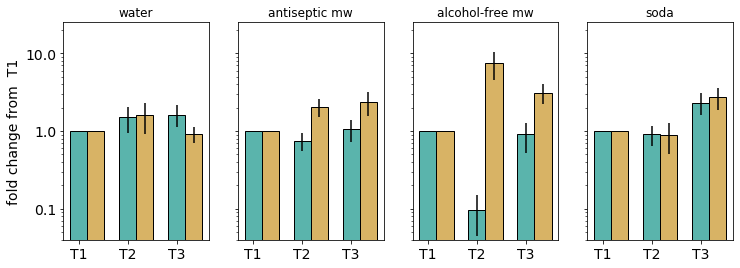

In [13]:
# PLOT
# set width of bar
barWidth = 0.35
# Set position of bar on X axis
r1 = np.arange(3)
r2 = [x + barWidth for x in r1]
labels = ('dud','T1','T2','T3')

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
f.set_size_inches(12,4)
# plot water
ax1.bar(r1, water['percent_live_t1_avg'], yerr=water['percent_live_t1_sem'], color='#5ab4ac', width=barWidth, edgecolor='black', label='live')
ax1.bar(r2, water['percent_dead_t1_avg'], yerr=water['percent_dead_t1_sem'],color='#d8b365', width=barWidth, edgecolor='black', label='dead')
ax1.set_yscale('log')
ax1.yaxis.set_major_formatter(mticker.ScalarFormatter())
ax1.set_ylim(.04,25)
ax1.set_title('water')
ax1.set_ylabel('fold change from  T1', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_xticklabels(labels)

# plot antiseptic_mouthwash
ax2.bar(r1, antiseptic_mouthwash['percent_live_t1_avg'], yerr=antiseptic_mouthwash['percent_live_t1_sem'], color='#5ab4ac', width=barWidth, edgecolor='black', label='live')
ax2.bar(r2, antiseptic_mouthwash['percent_dead_t1_avg'], yerr=antiseptic_mouthwash['percent_dead_t1_sem'],color='#d8b365', width=barWidth, edgecolor='black', label='dead')
ax2.set_title('antiseptic mw', fontsize=12)
ax2.set_xticklabels(labels, fontsize=14)

# plot alcohol_free_mouthwash
ax3.bar(r1, alcohol_free_mouthwash['percent_live_t1_avg'], yerr=alcohol_free_mouthwash['percent_live_t1_sem'], color='#5ab4ac', width=barWidth, edgecolor='black', label='live')
ax3.bar(r2, alcohol_free_mouthwash['percent_dead_t1_avg'], yerr=alcohol_free_mouthwash['percent_dead_t1_sem'],color='#d8b365', width=barWidth, edgecolor='black', label='dead')
ax3.set_title('alcohol-free mw')
ax3.set_xticklabels(labels, fontsize=14)

# plot soda
ax4.bar(r1, soda['percent_live_t1_avg'], yerr=soda['percent_live_t1_sem'], color='#5ab4ac', width=barWidth, edgecolor='black', label='live')
ax4.bar(r2, soda['percent_dead_t1_avg'], yerr=soda['percent_dead_t1_sem'],color='#d8b365', width=barWidth, edgecolor='black', label='dead')
ax4.set_title('soda')
ax4.set_xticklabels(labels, fontsize=14)


## Run statistics

In [14]:
# reformat data for statistical testing
dead = df[['saliva_sample_ID','timepoint','participant_id','Treatment_code',
           'percent_dead_t1','log_percent_dead_t1']]
dead.rename(index=str, columns={'percent_dead_t1':'percent_t1', 'log_percent_dead_t1':'log_percent_t1'}, inplace=True)
dead['timepoint_processing'] = dead.timepoint.astype(str) + '_dead'

live = df[['saliva_sample_ID','timepoint','participant_id','Treatment_code',
           'percent_live_t1','log_percent_live_t1']]
live.rename(index=str, columns={'percent_live_t1':'percent_t1', 'log_percent_live_t1':'log_percent_t1'}, inplace=True)
live['timepoint_processing'] = live.timepoint.astype(str) + '_live'

sf = dead.append(live)
df.head()

/Users/lisamarotz/miniconda2/envs/qiime2-2019.10/lib/python3.6/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)
/Users/lisamarotz/miniconda2/envs/qiime2-2019.10/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/lisamarotz/miniconda2/envs/qiime2-2019.10/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

,saliva_sample_ID,pma_FC_cells_per_ul_r1,pma_FC_cells_per_ul_r2,pma_FC_avg_cells_per_ul,pma_FC_avg_cells_5_min,timepoint,participant_id,Treatment_code,raw_FC_cells_per_ul_r1,raw_FC_cells_per_ul_r2,raw_FC_avg_cells_per_ul,raw_FC_avg_cells_5_min,dead_Cell5min,percent_dead_t1,percent_live_t1,log_percent_dead_t1,log_percent_live_t1
0,A1.1,11351,10854,11103,24425500,1,A1,A,66395,70173,68284,150224800,125799300,1.000000,1.000000,0.000000,0.000000
1,A1.2,27306,27451,27379,49281300,2,A1,A,106109,154696,130403,234724500,185443200,1.474119,2.017617,0.388061,0.701917
2,A1.3,108976,95640,102308,255770000,3,A1,A,1287629,2343931,1815780,4539450000,4283680000,34.051700,10.471434,3.527880,2.348651
3,A2.1,235,262,249,1167950,1,A2,A,1200,1401,1301,6112350,4944400,1.000000,1.000000,0.000000,0.000000
4,A2.2,164,182,173,726600,2,A2,A,1100,1397,1249,5243700,4517100,0.913579,0.622116,-0.090385,-0.474629


In [15]:
# seperate out groups by treatment code

In [16]:
A_ = sf[sf['Treatment_code']=='A']
B_ = sf[sf['Treatment_code']=='B']
C_ = sf[sf['Treatment_code']=='C']
D_ = sf[sf['Treatment_code']=='D']

### Water

In [17]:
A_.timepoint_processing.value_counts()

1_dead    7
1_live    7
3_dead    7
3_live    7
2_live    7
2_dead    7
Name: timepoint_processing, dtype: int64

In [18]:
# run one-way ANOVA with Tukey multiple comparison correction HSD
mc = MultiComparison(A_['log_percent_t1'], A_['timepoint_processing'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
1_dead 1_live      0.0   0.9   -1.57   1.57  False
1_dead 2_dead   0.0842   0.9 -1.4858 1.6542  False
1_dead 2_live  -0.0076   0.9 -1.5776 1.5624  False
1_dead 3_dead   0.2995   0.9 -1.2705 1.8695  False
1_dead 3_live   0.4576   0.9 -1.1124 2.0276  False
1_live 2_dead   0.0842   0.9 -1.4858 1.6542  False
1_live 2_live  -0.0076   0.9 -1.5776 1.5624  False
1_live 3_dead   0.2995   0.9 -1.2705 1.8695  False
1_live 3_live   0.4576   0.9 -1.1124 2.0276  False
2_dead 2_live  -0.0918   0.9 -1.6618 1.4782  False
2_dead 3_dead   0.2153   0.9 -1.3547 1.7853  False
2_dead 3_live   0.3734   0.9 -1.1966 1.9434  False
2_live 3_dead   0.3071   0.9 -1.2629 1.8771  False
2_live 3_live   0.4651   0.9 -1.1048 2.0351  False
3_dead 3_live   0.1581   0.9 -1.4119 1.7281  False
--------------------------------------------------


### Antiseptic mouthwash

In [19]:
B_.timepoint_processing.value_counts()

1_dead    7
1_live    7
3_dead    7
3_live    7
2_live    7
2_dead    7
Name: timepoint_processing, dtype: int64

In [20]:
# run one-way ANOVA with Tukey multiple comparison correction HSD
mc = MultiComparison(B_['log_percent_t1'], B_['timepoint_processing'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
1_dead 1_live      0.0    0.9 -1.0396 1.0396  False
1_dead 2_dead   0.5021 0.6726 -0.5375 1.5418  False
1_dead 2_live  -0.5119 0.6569 -1.5515 0.5277  False
1_dead 3_dead   0.5449  0.604 -0.4947 1.5845  False
1_dead 3_live  -0.2335    0.9 -1.2731 0.8061  False
1_live 2_dead   0.5021 0.6726 -0.5375 1.5418  False
1_live 2_live  -0.5119 0.6569 -1.5515 0.5277  False
1_live 3_dead   0.5449  0.604 -0.4947 1.5845  False
1_live 3_live  -0.2335    0.9 -1.2731 0.8061  False
2_dead 2_live   -1.014 0.0595 -2.0537 0.0256  False
2_dead 3_dead   0.0428    0.9 -0.9969 1.0824  False
2_dead 3_live  -0.7356  0.296 -1.7752  0.304  False
2_live 3_dead   1.0568 0.0445  0.0172 2.0964   True
2_live 3_live   0.2784    0.9 -0.7612  1.318  False
3_dead 3_live  -0.7784 0.2398  -1.818 0.2612  False
---------------------------------------------------


### Alcohol-free mouthwash

In [21]:
C_.timepoint_processing.value_counts()

1_dead    7
1_live    7
3_dead    7
3_live    7
2_live    7
2_dead    7
Name: timepoint_processing, dtype: int64

In [22]:
# run one-way ANOVA with Tukey multiple comparison correction HSD
mc = MultiComparison(C_['log_percent_t1'], C_['timepoint_processing'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
1_dead 1_live      0.0    0.9 -1.6286  1.6286  False
1_dead 2_dead   1.3451 0.1556 -0.2835  2.9738  False
1_dead 2_live  -3.2797  0.001 -4.9084 -1.6511   True
1_dead 3_dead   0.8621 0.5953 -0.7666  2.4907  False
1_dead 3_live  -0.5537    0.9 -2.1823  1.0749  False
1_live 2_dead   1.3451 0.1556 -0.2835  2.9738  False
1_live 2_live  -3.2797  0.001 -4.9084 -1.6511   True
1_live 3_dead   0.8621 0.5953 -0.7666  2.4907  False
1_live 3_live  -0.5537    0.9 -2.1823  1.0749  False
2_dead 2_live  -4.6249  0.001 -6.2535 -2.9963   True
2_dead 3_dead  -0.4831    0.9 -2.1117  1.1455  False
2_dead 3_live  -1.8988 0.0144 -3.5274 -0.2702   True
2_live 3_dead   4.1418  0.001  2.5132  5.7704   True
2_live 3_live    2.726  0.001  1.0974  4.3547   True
3_dead 3_live  -1.4157 0.1198 -3.0444  0.2129  False
----------------------------------------------

### Soda

In [23]:
D_.timepoint_processing.value_counts()

1_dead    7
1_live    7
3_dead    7
3_live    7
2_live    7
2_dead    7
Name: timepoint_processing, dtype: int64

In [24]:
# run one-way ANOVA with Tukey multiple comparison correction HSD
mc = MultiComparison(D_['log_percent_t1'], D_['timepoint_processing'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
1_dead 1_live      0.0    0.9  -1.634  1.634  False
1_dead 2_dead  -0.5285    0.9 -2.1625 1.1055  False
1_dead 2_live  -0.4527    0.9 -2.0867 1.1813  False
1_dead 3_dead   0.5008    0.9 -1.1332 2.1348  False
1_dead 3_live   0.2305    0.9 -1.4035 1.8645  False
1_live 2_dead  -0.5285    0.9 -2.1625 1.1055  False
1_live 2_live  -0.4527    0.9 -2.0867 1.1813  False
1_live 3_dead   0.5008    0.9 -1.1332 2.1348  False
1_live 3_live   0.2305    0.9 -1.4035 1.8645  False
2_dead 2_live   0.0758    0.9 -1.5582 1.7098  False
2_dead 3_dead   1.0293 0.4233 -0.6046 2.6633  False
2_dead 3_live    0.759 0.7035  -0.875  2.393  False
2_live 3_dead   0.9535 0.5048 -0.6805 2.5875  False
2_live 3_live   0.6832  0.781 -0.9508 2.3172  False
3_dead 3_live  -0.2703    0.9 -1.9043 1.3636  False
---------------------------------------------------
